# <center> Forecasting City Finances - Data Wrangling </center>


## Import Packages
The needed packages for treating the data are imported below:

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

## Load the data
The data file which is in the form of a csv is loaded and stored as a raw dataframe. The column names are printed to have a first idea of what fields are in the raw data.

In [2]:
# load in raw data
pwd_raw_data = '/Users/Varishth/Desktop/Springboard_Projects/capstone_two/data/raw_fisc_data.csv'
raw_df = pd.read_csv(pwd_raw_data)

# Print all column names
raw_df.columns

Index(['year', 'city_name', 'city_types', 'id_city', 'city_population', 'cpi',
       'rev_total_city', 'rev_general_city', 'intergovt_rev_city',
       'igr_federal_city',
       ...
       'cash_other_offsets', 'cash_other_bonds', 'cash_other_other',
       'county_name', 'id_county', 'county_population',
       'relationship_city_school', 'enrollment', 'districts_in_city',
       'consolidated_govt'],
      dtype='object', length=663)

An initial exploration of the available fields shows that the fields are repeated with different suffixes (such as 'city', and 'cnty', etc...). To choose which of the repeated fields are of interest, we check the original source of where the data is published. Since we are interested only in the fiscally standardized fields, we can limit the raw data to only 'fisc' fields.

In [3]:
# Aside from FiSC (Fiscally Standardized Cities) this data set is made up of 
# city-level, county-level, district school-level and special district-level data.
# Since we will be only concerned with the FiSC data, we can filter out the other levels.
raw_df_fisc = raw_df.drop(raw_df.filter(regex=r'(_city|_cnty|_schl|_spec)').columns, axis=1)
raw_df_fisc_col = raw_df_fisc.columns

# Print all column names
raw_df_fisc_col

Index(['year', 'city_name', 'city_types', 'city_population', 'cpi',
       'rev_total', 'rev_general', 'intergovt_rev', 'igr_federal', 'igr_state',
       ...
       'cash_empl_retire', 'cash_other', 'cash_other_offsets',
       'cash_other_bonds', 'cash_other_other', 'county_name', 'id_county',
       'county_population', 'enrollment', 'consolidated_govt'],
      dtype='object', length=139)

## Deal with NA or NULL data

### 1. Deal null data:
We first explore each of the columns and count the number of null in each of them, to identify fields with null.

In [4]:
for i in range(len(raw_df_fisc_col)):
    if sum(raw_df_fisc[raw_df_fisc_col[i]].isnull()) != 0:
        print(raw_df_fisc_col[i], " :", sum(raw_df_fisc[raw_df_fisc_col[i]].isnull()))

county_name  : 861
id_county  : 1457
county_population  : 855
enrollment  : 400
consolidated_govt  : 246


From the above search for null values, only 5 out of 139 fields had them: "county_name", "id_county", "county_population", enrollment" and "consolidated_govt". Upon cross-checking the origin of the database and description of the field list, these exact 5 fields were not listed as intended fields for the report. Therefore it can be concluded that these fields should not be present in the database and were likely erroneously entered. For this reason, we can exclude these fields from our study.

In [5]:
# Drop the erroneously entered fields
df_fisc = raw_df_fisc.drop(["county_name", "id_county", "county_population", "enrollment", "consolidated_govt"], axis=1)

# Verify that none of the remaining data is null
print("Total number of 'null' data left = ", df_fisc.isnull().sum().sum())
print("Shape of df_fisc:", df_fisc.shape)

Total number of 'null' data left =  0
Shape of df_fisc: (8938, 134)


### 2. Deal 'NA' data:
Now that we have removed all the null data we can move on to data appearing as "NA".

In [6]:
df_fisc_col = df_fisc.columns
for i in range(len(df_fisc_col)):
    if  sum(df_fisc[df_fisc_col[i]].isna()) != 0:
        print(df_fisc_col[i], " :", sum(df_fisc[df_fisc_col[i]].isna()))

None of the fields have any NA data, but to make sure we did not miss any, we can check the total sum of all NA data:

In [7]:
# Verify that none of the remaining data is na
print("Total number of 'NA' data left = ", df_fisc.isna().sum().sum())

Total number of 'NA' data left =  0


## Cleaning by Data Types

First we need to identify all the data types that we have in our df_fisc data:

In [8]:
for i in range(len(df_fisc_col)):
    print(df_fisc_col[i], " :", df_fisc[df_fisc_col[i]].dtypes)

year  : int64
city_name  : object
city_types  : object
city_population  : int64
cpi  : float64
rev_total  : float64
rev_general  : float64
intergovt_rev  : float64
igr_federal  : float64
igr_state  : float64
own_source_rev  : float64
taxes  : float64
tax_property  : float64
tax_sales_grossrec  : float64
tax_sales_general  : float64
tax_sales_selectiv  : float64
tax_sales_motofuel  : float64
tax_sales_alcohol  : float64
tax_sales_tobacco  : float64
tax_sales_utility  : float64
tax_sales_other  : float64
tax_income_indiv  : float64
tax_income_corp  : float64
tax_motor_vehicle  : float64
tax_other  : float64
charges_misc_rev  : float64
charges  : float64
chg_educ  : float64
chg_higher_ed  : float64
chg_school_lunch  : float64
chg_hospitals  : float64
chg_highways  : float64
chg_air_transit  : float64
chg_parking  : float64
chg_seaport  : float64
chg_nat_resources  : float64
chg_parks_rec  : float64
chg_hous_commdev  : float64
chg_sewers  : float64
chg_waste_mgmt  : float64
chg_other  : fl

As expected, almost all the fields have the data type 'float64' since they should represent sources of income and expenditures for the cities. The non-float fields are *'year'*, *'city_name'*, *'city_types'*, and *'city_population'*. 'year' is in integer which is not a problem. 'city_population' is in integer format which also makes sense, and 'city_name' and 'city_types' are in object format, which could signify a mixed data input (numbers where strings are expected) and therefore require more exploration.

For 'city_name', the object format is because of the colon which separates the state and the city names for each entry. Finally checking 'city_types' - it has the object format because some entries have the following character "|". This should not pose a problem and therefore no cleaning is required here.

## Addressing Outliers

We use the `describe` method to obtain the basic statistics for each field and to get a sense of the range of each field.

In [9]:
pd.set_option('display.max_rows', 135)
df_fisc.describe().T

,count,mean,std,min,25%,50%,75%,max
year,8938.0,1997.000000,11.832822,1977.00,1987.000000,1997.000000,2007.000000,2.017000e+03
city_population,8938.0,298271.366413,638248.946402,15531.00,65970.750000,156486.500000,313063.000000,8.475976e+06
cpi,8938.0,1.769213,0.752340,1.00,1.182201,1.527227,2.157747,4.044885e+00
rev_total,8938.0,5181.352746,1976.160484,1389.30,3804.260000,4859.640000,6228.987500,2.138192e+04
rev_general,8938.0,4562.245882,1710.773984,1472.00,3418.587500,4242.510000,5386.752500,1.993670e+04
intergovt_rev,8938.0,1845.716405,914.593868,276.95,1202.002500,1634.625000,2298.637500,1.210710e+04
igr_federal,8938.0,331.260246,372.660200,1.65,164.032500,260.110000,403.825000,6.359350e+03
igr_state,8938.0,1514.096518,835.974639,0.00,911.985000,1338.370000,1923.262500,1.142680e+04
own_source_rev,8938.0,2714.615782,1194.005373,779.44,1967.497500,2491.300000,3157.265000,1.411041e+04
taxes,8938.0,1657.967598,817.751363,335.83,1185.892500,1515.110000,1953.192500,1.122387e+04


Large ranges and large standard deviations are noted. This was expected because of the difference in size of the cities involved in the study. To further visualize these ranges, we can plot histograms for each field.

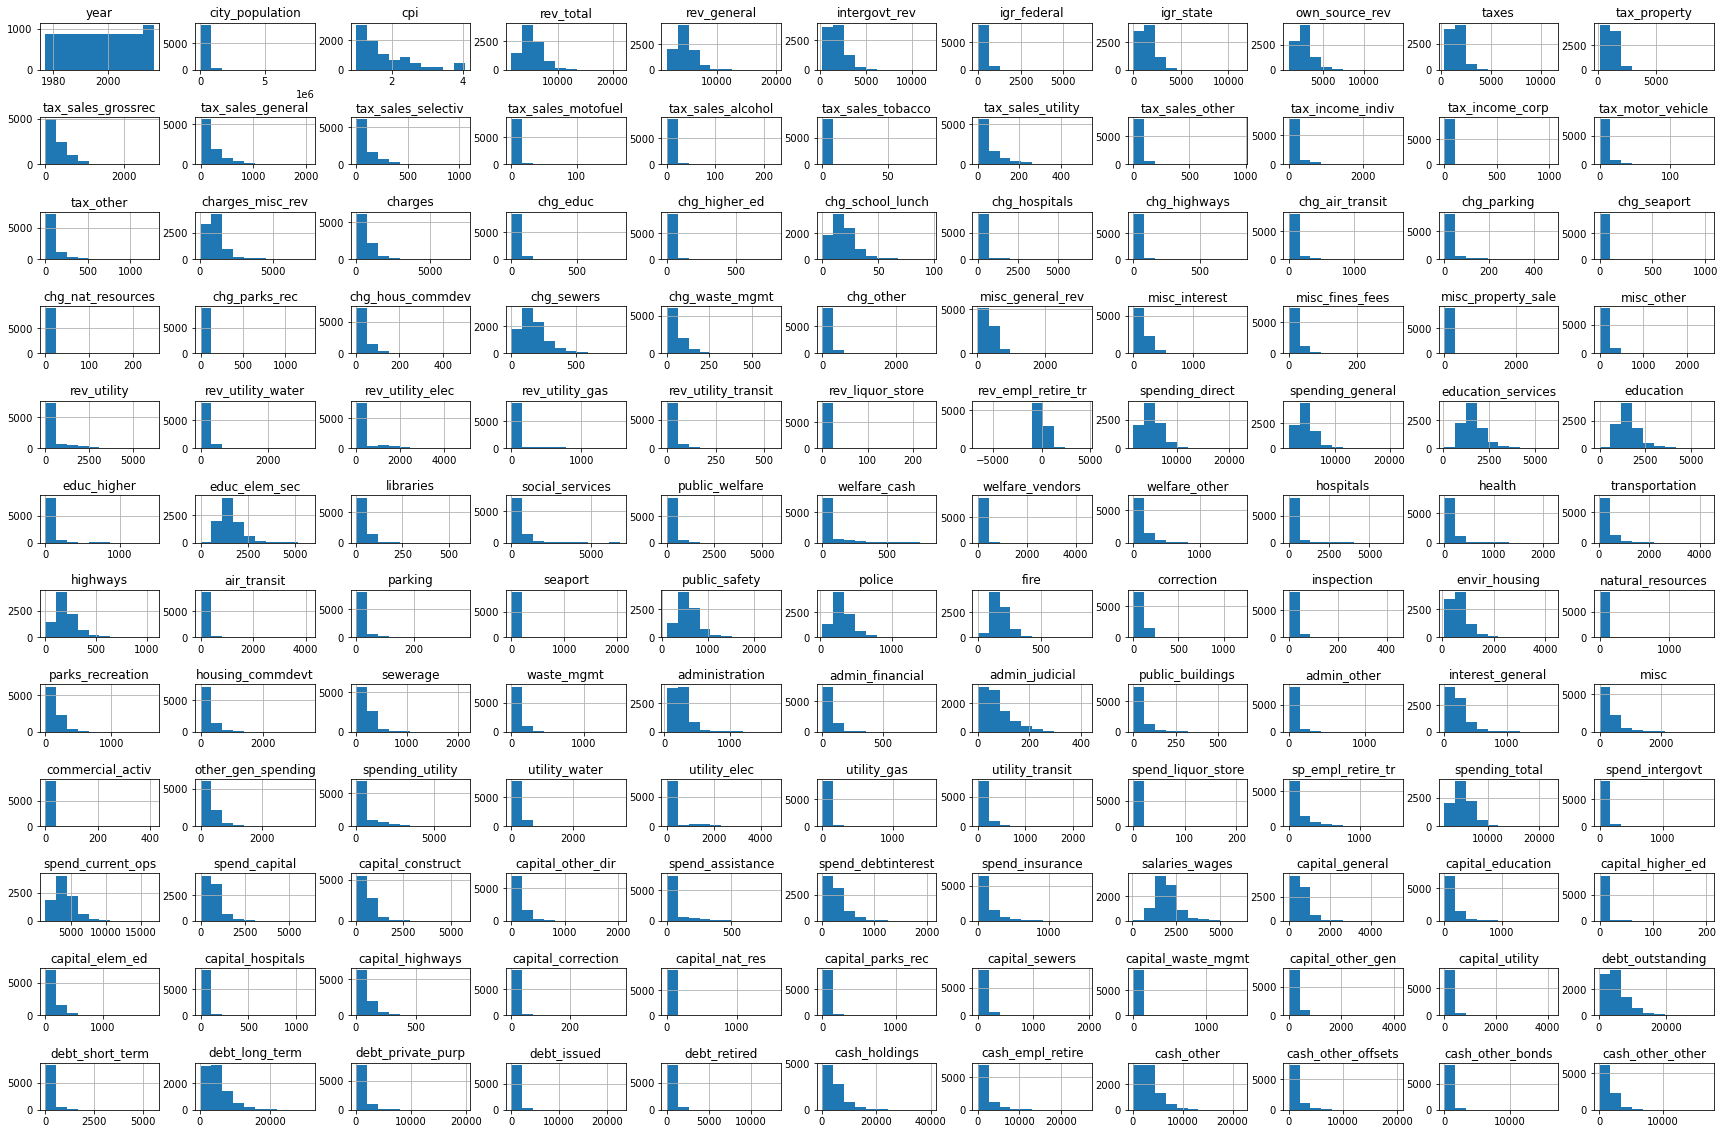

In [10]:
df_fisc.hist(figsize=(30,20))
plt.subplots_adjust(hspace=1);

We note that there are several fields where the values are concentrated towards the lower end but the range extends much further. For example, we can focus on 'misc_property_sale' (row 7 & column 8 in above histograms) which seems to have only values concentrated close to zero but the max value extends close to 3000. We can take a further look specifically at 'misc_property_sale' to understand what drives this large range.

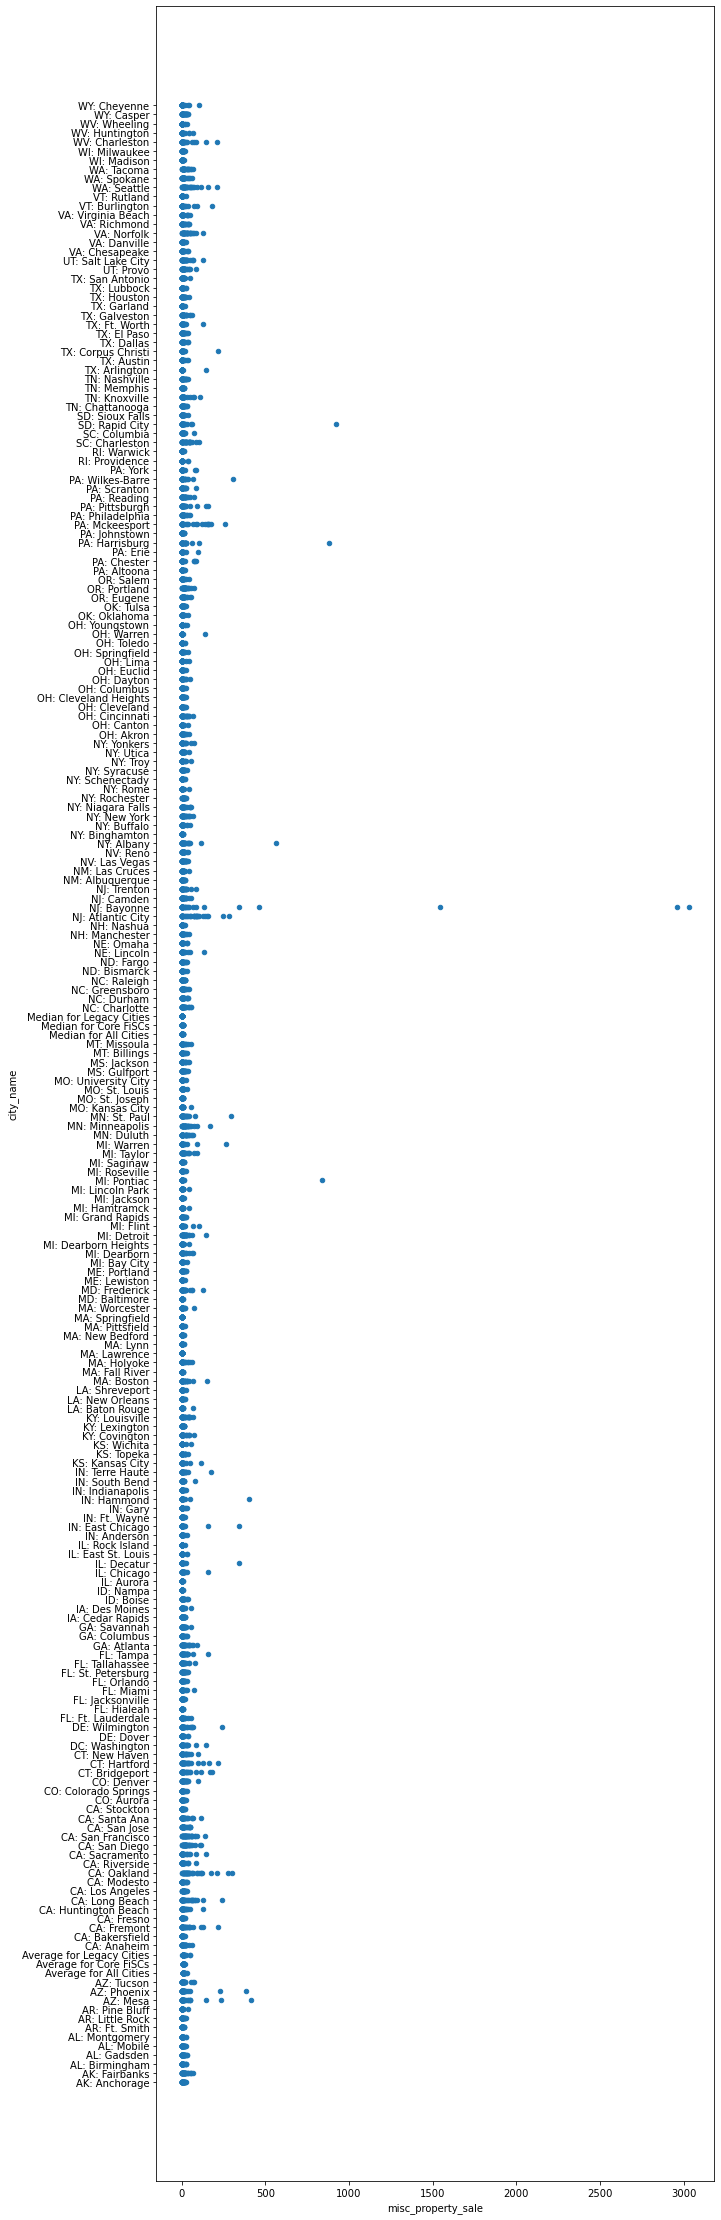

In [11]:
_ = df_fisc.plot.scatter(y= 'city_name', x='misc_property_sale',figsize=(10,40))

The range is extended by a few outliers, specifically for the NJ: Bayonne city entry. This signals that there is potentially erroneous data for this city. We confirm this by plotting specifically 'misc_property_sale' for other cities in NJ for all years.

Text(0, 0.5, 'count')

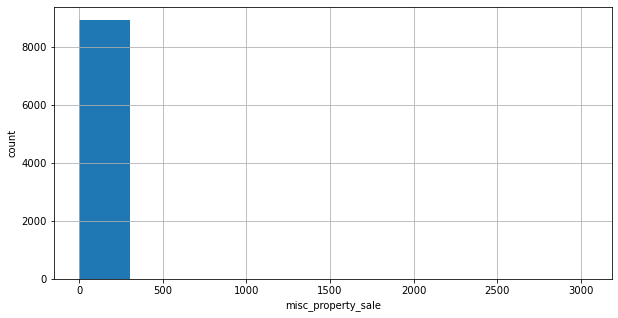

In [19]:
df_fisc.misc_property_sale.hist(figsize=(10,5))
plt.xlabel('misc_property_sale')
plt.ylabel('count')

Text(0, 0.5, 'misc_property_sale')

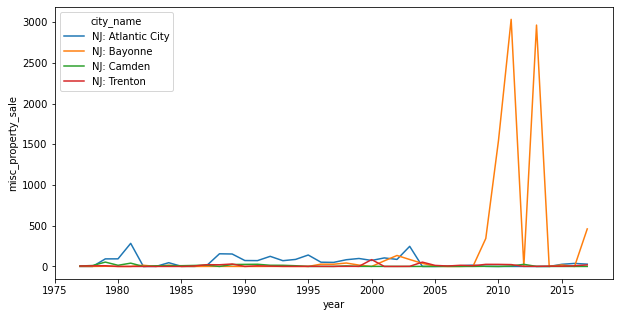

In [20]:
NJ_misc_prop_sale = df_fisc[df_fisc["city_name"].str.contains('NJ: ')][['year', 'city_name', 'misc_property_sale']]
NJ_misc_prop_sale.pivot(index='year', columns='city_name', values='misc_property_sale').plot.line(figsize=(10,5))
plt.ylabel('misc_property_sale')

As we can see, for 2 years, 2010 and 2013, NJ: Bayonne has two very large (~300x higher) values for 'misc_property_sale'. From further external research, there is also no evidence that for these years, significant property sales occurred in Bayonne. One way to fix this outlier would be to replace it with the average of neighboring non-outlier values. Given that not all cities, and not all fields will be used in the modeling, the necessary changes for outliers can be applied once the choices of fields are made during EDA.

## Check for duplicate entries

Finally, we must ensure that there are no repeating entries for a specific city and a specific year.

In [13]:
print("Total number of duplicate entries = ", df_fisc.duplicated(subset=['year','city_name']).sum())

Total number of duplicate entries =  0


## Save cleaned dataframe to a new csv file

In [14]:
df_fisc.to_csv(r'/Users/Varishth/Desktop/Springboard_Projects/capstone_two/data/clean_fisc_data.csv',index=False)